In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import h5py

/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
h5f = h5py.File('../data/karim_stacked_fluxes', 'r')

In [3]:
X_test = h5f['X_test']

In [ ]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [48]:
import cobra
%load_ext autoreload
import sys
if not '/home/nlarusstone/cf_fba' in sys.path:
    sys.path.append('/home/nlarusstone/cf_fba')
import src.utils as utils
import src.flux_utils as futils
import src.vae as model_builder
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('../data/Karim_MetEng_2018_Figure2_Data.csv')
df.drop(columns=['Area_1', 'Area_2', 'Conc_1', 'Conc_2'], inplace=True)
n_experiments = df.shape[0]
df.head()

,AVG,STD,AVG.1,STD.1,Mg(Glu)2,NH4(Glu),K(Glu),Glucose,K2HPO4,NAD,ATP,CoA
0,0.00,0.0,0.00,0.00,8.0,10.0,134,0,10,0.5,0.0,0.5
1,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.0,0.0,0.5
2,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,2.0
3,0.00,0.0,0.00,0.00,8.0,10.0,134,200,10,0.5,0.0,1.6
4,1.21,1.7,0.09,0.13,8.0,10.0,134,200,10,0.5,2.0,0.5


In [51]:
#X_train, y_train, X_test, y_test, btol_col, cols = futils.read_data('../data/flux_samps_2k', scale='flux_zero')
y_vals = futils.scale_data(data=df['AVG.1'].values, scale_type='flux_zero', in_place=False)

1


In [94]:
batch_size = 256
X_shape, n_experiments = X_train.shape[2], df.shape[0]
targets = tf.convert_to_tensor(y_vals, dtype=tf.float32)
latent_dim = 2
use_corr = True
scale = 'flux_zero'
vae, encoder, generator = model_builder.build_vae(X_shape, n_experiments, targets, btol_col, [1024, 256], 
                                                  latent_dim, batch_size, use_corr, scale)
es = EarlyStopping(patience=5)
lh = model_builder.LossHistory()
#with tf.Session(config=tf.ConfigProto(
#                    intra_op_parallelism_threads=32)) as sess:
#    K.set_session(sess)
hist = vae.fit(X_train,
        shuffle=True,
        epochs=20,
        batch_size=batch_size,
        validation_data=(X_test, None),
        callbacks=[es, lh])

sigmoid
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 41, 2639)     0                                            
__________________________________________________________________________________________________
dense_41 (Dense)                (None, 41, 1024)     2703360     input_18[0][0]                   
__________________________________________________________________________________________________
dense_42 (Dense)                (None, 41, 256)      262400      dense_41[0][0]                   
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 41, 2)        514         dense_42[0][0]                   
__________________________________________________________________________________________________
z_

/home/nlarusstone/cf_fba/src/vae.py:119 UserWarning: Output "dense_45" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_45" during training.


Train on 37500 samples, validate on 12500 samples
Epoch 1/20
37500/37500 [==============================] - 151s 4ms/step - loss: 102.1737 - val_loss: 78.4934


NameError: global name 'df' is not defined

In [60]:
from keras.models import load_model
#enc = load_model('../models/encoder_epochs=300_batch=256_dimension=2_corr=True.h5')
enc = load_model('../models/encoder_epochs=100_batch=256_dimension=2_corr=True_scale=flux_zero.h5')
#gen = load_model('../models/generator_epochs=300_batch=256_dimension=2_corr=True.h5')
gen = load_model('../models/generator_epochs=100_batch=256_dimension=2_corr=True_scale=flux_zero.h5')

In [6]:
test_enc = enc.predict(X_test)
test_dec = gen.predict(test_enc)
#dec_df = pd.DataFrame(data=test_dec[:, 0, :], columns=cols)

In [7]:
model = cobra.io.read_sbml_model('../models/ecoli_cf_base.sbml')

In [ ]:
for j in range(41):
    a = pd.DataFrame(data=test_dec[:, j, :], columns=cols)
    a.mean().plot(kind='hist')
    print test_dec[:, j, btol_col].mean()
    plt.show()

In [8]:
thresh = np.logspace(start=-4, stop=0, num=20)
for t in thresh:
    objs = []
    for i, row in df.iterrows():
        model_i = utils.add_reagents_to_model(model, row)
        dec_df = pd.DataFrame(data=test_dec[:, i, :], columns=cols)
        bad_cols = cols[dec_df.mean().abs() < t]
        model_i.remove_reactions(bad_cols)
        sol = model_i.optimize()
        objs.append(sol.objective_value)
    print t, scipy.stats.pearsonr(objs, df['AVG.1'])

cobra/core/model.py:608 UserWarning: DM_nad_e not in iJO1366
cobra/core/model.py:608 UserWarning: DM_atp_e not in iJO1366


0.0001 (-0.18599663675596972, 0.24429322068475864)
0.0001623776739188721 (-0.18599663675598155, 0.24429322068472673)
0.00026366508987303583 (-0.18599663675598407, 0.24429322068472123)
0.00042813323987193956 (-0.18599663675597242, 0.24429322068475035)
0.0006951927961775605 (-0.18599663675597605, 0.24429322068474038)
0.0011288378916846883 (-0.1421659247369407, 0.3752565173078518)
0.0018329807108324356 (-0.06991347425715992, 0.6640323693780252)


cobra/core/model.py:608 UserWarning: EX_glc__D_e not in iJO1366


0.002976351441631319 (0.13862552754506213, 0.38738453729669353)
0.004832930238571752 (0.15481930374238032, 0.33378693058805886)
0.007847599703514606 (0.2178814867370697, 0.1711607265545529)
0.012742749857031334 (0.09724742205034753, 0.5452674045274182)
0.0206913808111479 (0.06700389023702961, 0.6772383967538836)


cobra/util/solver.py:403 UserWarning: solver status is 'infeasible'


0.03359818286283781 (0.05977586027312816, 0.7104529828100246)
0.05455594781168514 (nan, 1.0)


/home/nlarusstone/.virtualenvs/nls/lib/python2.7/site-packages/scipy/stats/stats.py:3010 RuntimeWarning: invalid value encountered in double_scalars


0.08858667904100823 (nan, 1.0)


cobra/core/model.py:608 UserWarning: EX_pi_e not in iJO1366


0.14384498882876628 (nan, 1.0)
0.23357214690901212 (nan, 1.0)
0.3792690190732246 (nan, 1.0)
0.615848211066026 (nan, 1.0)
1.0 (nan, 1.0)


In [27]:
scale_type = ['norm', 'robust', 'maxabs', 'negone', 'zero']
dirs = ['flux', 'exp']

In [46]:
import pickle
import itertools
def compare_losses(category, opts):
    cats = ['epochs', 'batch', 'dimension', 'corr', 'scale']
    dvs = [100, 256, 2, True, 'flux_zero']
    idx = cats.index(category)
    del cats[idx]
    del dvs[idx]
    defdict = dict(zip(cats, dvs))
    for opt in opts:
        curdict = defdict.copy()
        curdict.update({category: opt})
        with open('../models/losses_epochs={epochs}_batch={batch}_dimension={dimension}_corr={corr}_scale={scale}.h5'.format(
            **curdict
        ), 'r') as f:
            losses = pickle.load(f)
            print opt, [ls[-1] for k, ls in losses.items()]
#compare_losses('scale', ["{0}_{1}".format(d, st) for d, st in itertools.product(dirs, scale_type)])
compare_losses('dimension', [2, 3, 5, 7, 10])

2 [41.496534183643405, -0.8662801478631902, 5.800572]
3 [34.14316380664355, -0.9671185770776196, 7.6588693]
5 [29.442921705464354, -0.9697774771241698, 9.7291155]
7 [28.559490263091686, -0.9750429846651395, 10.84863]
10 [27.531898823747497, -0.9712822940015329, 11.860467]


In [91]:
a = pd.DataFrame(data=test_dec[~high_cols, i, :], columns=cols)
print a.shape
a.head()

(4924, 2639)


,DM_4CRSOL,DM_5DRIB,DM_AACALD,DM_AMOB,DM_MTHTHF,DM_OXAM,Ec_biomass_iJO1366_WT_53p95M,Ec_biomass_iJO1366_core_53p95M,EX_12ppd__R_e,EX_12ppd__S_e,...,EX_lystrna_e,EX_mettrna_e,EX_trptrna_e,EX_phetrna_e,EX_protrna_e,EX_trnaser_e,EX_pi_e,DM_nad_e,EX_glc__D_e,DM_atp_e
0,-0.881620,-0.952770,0.221703,-0.878268,-0.952690,-0.869516,-0.910346,-0.981879,-0.961939,-0.952128,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.784893,-1.0,-0.947766,-1.0
1,-0.874308,-0.951368,0.220867,-0.871271,-0.952661,-0.860171,-0.904585,-0.981454,-0.960719,-0.949570,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.775824,-1.0,-0.946561,-1.0
2,-0.882721,-0.953055,0.220833,-0.879363,-0.952676,-0.871300,-0.911253,-0.981939,-0.962071,-0.952551,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.785955,-1.0,-0.947947,-1.0
3,-0.879922,-0.952333,0.223029,-0.876578,-0.952711,-0.866749,-0.908944,-0.981788,-0.961736,-0.951474,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.783264,-1.0,-0.947488,-1.0
4,-0.879030,-0.952144,0.223071,-0.875704,-0.952702,-0.865490,-0.908212,-0.981745,-0.961605,-0.951160,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.782239,-1.0,-0.947333,-1.0


In [89]:
diff = pd.DataFrame(data=X_test[high_cols, 0, :], columns=cols)
diff.head()

,DM_4CRSOL,DM_5DRIB,DM_AACALD,DM_AMOB,DM_MTHTHF,DM_OXAM,Ec_biomass_iJO1366_WT_53p95M,Ec_biomass_iJO1366_core_53p95M,EX_12ppd__R_e,EX_12ppd__S_e,...,EX_lystrna_e,EX_mettrna_e,EX_trptrna_e,EX_phetrna_e,EX_protrna_e,EX_trnaser_e,EX_pi_e,DM_nad_e,EX_glc__D_e,DM_atp_e
0,0.860305,-0.992520,0.546359,0.860305,-0.996996,-0.999251,-0.997714,0.921274,-0.997882,-0.987626,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.452351,-1.0,-1.0,-1.0
1,0.861491,-0.992516,0.546638,0.861491,-0.998854,-0.999251,-0.996491,0.921236,-0.988797,-0.987626,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.451945,-1.0,-1.0,-1.0
2,0.868062,-0.992489,0.545910,0.868062,-0.998939,-0.993183,-0.998231,0.929830,-0.997888,-0.987626,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.450247,-1.0,-1.0,-1.0
3,1.000000,-0.991758,-0.345146,1.000000,-0.961284,-0.999914,1.000000,-0.999982,-0.999976,-0.999966,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.421753,-1.0,-1.0,-1.0
4,0.783807,-0.992833,-0.345147,0.783807,-0.999177,-0.999659,-0.999996,0.844531,-0.999965,-0.999946,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.803070,-1.0,-1.0,-1.0


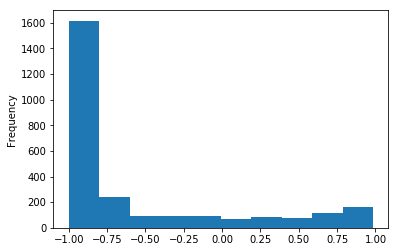

In [93]:
a.mean().plot(kind='hist')

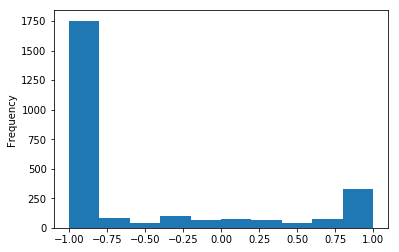

In [92]:
diff.mean().plot(kind='hist')

76


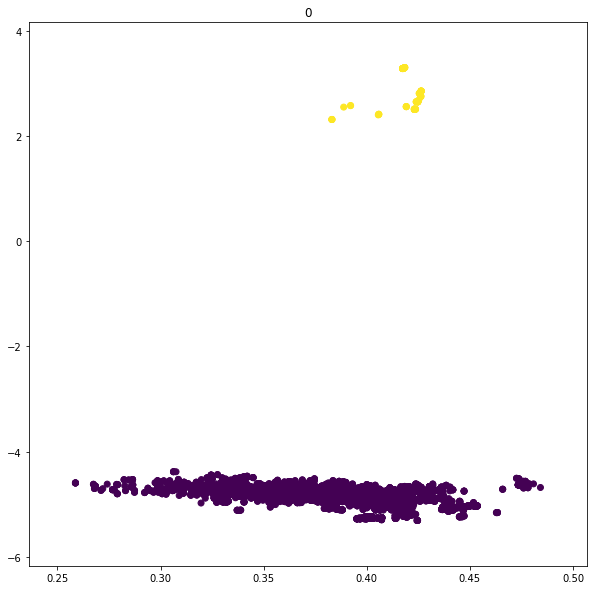

In [82]:
x_test_encoded = test_enc

def get_rct(df, rct, y_test):
    y_new = []
    for ind in y_test:
        y_new.append(df[rct][ind])
    return y_new

cmap = cm.get_cmap('plasma', 41)
#for j in range(4):
j = 0

high_cols = (test_enc[:, j, 1] > 0)
print sum(high_cols)
xmin, xmax = np.amin(x_test_encoded[:, j, 0]), np.amax(x_test_encoded[:, j, 0])
ymin, ymax = np.amin(x_test_encoded[:, j, 1]), np.amax(x_test_encoded[:, j, 1])
x_diff = (xmax - xmin) / 10.0
y_diff = (ymax - ymin) / 10.0
#for col in df.columns[4:]:
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, j, 0], x_test_encoded[:, j, 1], c=high_cols)#get_rct(df, col, y_test), cmap=cmap)
plt.xlim((xmin - x_diff, xmax + x_diff))
plt.ylim((ymin - y_diff, ymax + y_diff))
plt.title(j)
#plt.colorbar()
plt.show()